In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from spdt import NaiveStreamForest, CascadeStreamForest

In [3]:
# Define color palette
sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [4]:
def write_result(filename, acc_ls):
    output = open(filename, "w")
    for acc in acc_ls:
        output.write(str(acc))


def load_result(filename):
    """
    Loads results from specified file
    """
    inputs = open(filename, "r")
    lines = inputs.readlines()
    ls = []
    for line in lines:
        if line[0] == "A":
            ls.append(float(line.strip().split()[-1]))
    return ls

In [5]:
def prediction(classifier):
    predictions = classifier.predict(X_test)

    p_t = 0
    for i in range(X_test.shape[0]):
        if predictions[i] == y_test[i]:
            p_t += 1

    return p_t / X_test.shape[0]

In [80]:
inputs = open("splice.data", "r")
lines = inputs.readlines()
labels = []
IDs = []
DNAs = []
for line in lines:
    data = line.strip().split()
    labels.append(data[0][:-1])
    IDs.append(data[1][:-1])
    DNAs.append(data[2])

In [81]:
for i in range(60):
    feature = []
    for j in range(len(DNAs)):
        feature.append(DNAs[j][i])
    if i == 0:
        df = pd.DataFrame(feature, columns=["Pos"+str(i)])
        first = False
    else:
        df["Pos"+str(i)] = feature

In [82]:
df["Label"] = labels
letters = ["A", "C", "G", "T", "D", "N", "S", "R", "EI", "IE", "N"]
nums = [0.25, 0.5, 0.75, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0]
df.replace(letters, nums, inplace=True)

In [ ]:
df.to_csv("dna.csv", index=False)

In [7]:
df = pd.read_csv("dna.csv")

In [8]:
X = df.drop(["Label"], axis=1).values
y = df["Label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [90]:
for i in range(100, 2300, 100):
    dump_svmlight_file(X_train[:i], y_train[:i], "splice_train_"+str(i))

In [89]:
dump_svmlight_file(X_test, y_test, "splice_test")

In [14]:
def experiment_small_rf():
    rf_l = []

    rf = RandomForestClassifier(n_jobs=-1)

    for i in range(23):
        rf.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        rf_l.append(prediction(rf))

    return rf_l


def experiment_small_et():
    rf_l = []

    rf = ExtraTreesClassifier(n_jobs=-1)

    for i in range(23):
        rf.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        rf_l.append(prediction(rf))

    return rf_l


def experiment_small_dt():
    dt_l = []

    dt = DecisionTreeClassifier()

    for i in range(23):
        dt.fit(X_r[: (i + 1) * 100], y_r[: (i + 1) * 100])
        dt_l.append(prediction(dt))

    return dt_l


def experiment_small_s():
    sdt_l = []
    nsf_l = []
    csf_l = []
    net_l = []
    cet_l = []

    sdt = DecisionTreeClassifier()
    nsf = NaiveStreamForest()
    csf = CascadeStreamForest()
    net = NaiveStreamForest(splitter="random")
    cet = CascadeStreamForest(splitter="random")

    for i in range(23):
        X_t = X_r[i * 100 : (i + 1) * 100]
        y_t = y_r[i * 100 : (i + 1) * 100]

        sdt.partial_fit(X_t, y_t)
        sdt_l.append(prediction(sdt))

        nsf.fit(X_t, y_t)
        nsf_l.append(prediction(nsf))

        csf.fit(X_t, y_t)
        csf_l.append(prediction(csf))

        net.fit(X_t, y_t)
        net_l.append(prediction(net))

        cet.fit(X_t, y_t)
        cet_l.append(prediction(cet))

    return sdt_l, nsf_l, csf_l, net_l, cet_l

In [15]:
results = []
for i in range(10):
    p = np.random.permutation(X_train.shape[0])

    X_r = X_train[p]
    y_r = y_train[p]

    result = []
    result.append(experiment_small_rf())
    result.append(experiment_small_et())
    result.append(experiment_small_dt())
    sdt_l, nsf_l, csf_l, net_l, cet_l = experiment_small_s()
    result.append(sdt_l)
    result.append(nsf_l)
    result.append(csf_l)
    result.append(net_l)
    result.append(cet_l)
    results.append(result)

    with open("dna_results.txt", "wb") as f:
        pickle.dump(results, f)

In [ ]:
with open("dna_results.txt", "rb") as f:
    results = pickle.load(f)

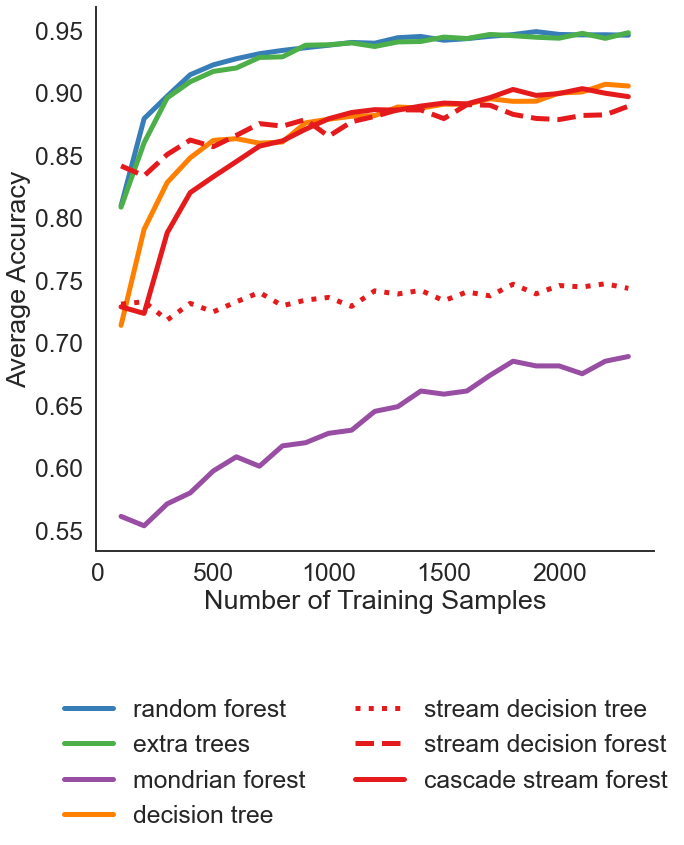

In [19]:
# impurity same version
means = np.mean(results, axis=0)
mon = load_result("dna_result")
n_train = range(100, 2400, 100)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Average Accuracy")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest", lw=5)
plt.plot(n_train, means[1], label="extra trees", lw=5)
plt.plot(n_train, mon, label="mondrian forest", lw=5)
# plt.plot(num, ht, label="hoeffding trees",lw=5,color="#ff7f00")
# plt.plot(num, hat, label="hoeffding adaptive trees",lw=5,color="#ffff33")
plt.plot(n_train, means[2], label="decision tree", lw=5)
plt.plot(
    n_train,
    means[3],
    label="stream decision tree",
    lw=5,
    color="#e41a1c",
    linestyle="dotted",
)
plt.plot(
    n_train,
    means[4],
    label="stream decision forest",
    lw=5,
    color="#e41a1c",
    linestyle="dashed",
)
plt.plot(n_train, means[5], label="cascade stream forest", lw=5, color="#e41a1c")
# plt.plot(n_train, means[6], label="stream extra trees", lw=5)
# plt.plot(n_train, means[7], label="cascade extra trees", lw=5)

leg = plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="upper center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

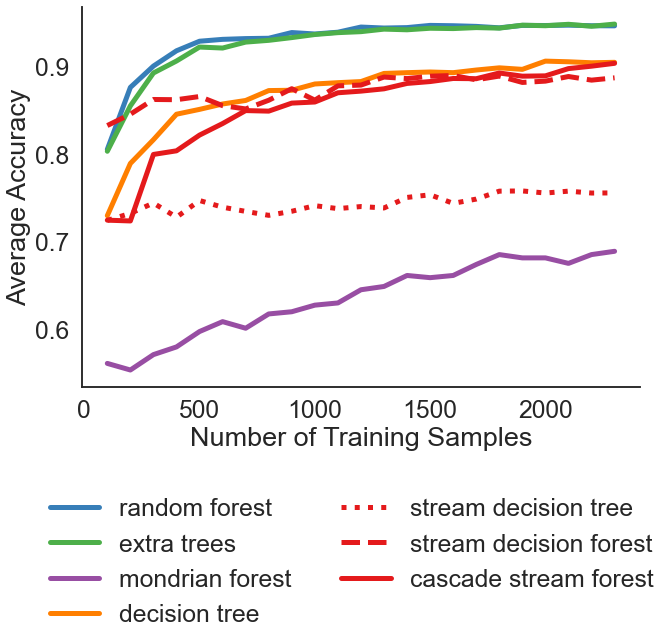

In [9]:
# impurity same version
means = np.mean(results, axis=0)
mon = load_result("dna_result")
n_train = range(100, 2400, 100)
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

ax.set_xlabel("Number of Training Samples")
ax.set_ylabel("Average Accuracy")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot(n_train, means[0], label="random forest", lw=5)
plt.plot(n_train, means[1], label="extra trees", lw=5)
plt.plot(n_train, mon, label="mondrian forest", lw=5)
# plt.plot(num, ht, label="hoeffding trees",lw=5,color="#ff7f00")
# plt.plot(num, hat, label="hoeffding adaptive trees",lw=5,color="#ffff33")
plt.plot(n_train, means[2], label="decision tree", lw=5)
plt.plot(
    n_train,
    means[3],
    label="stream decision tree",
    lw=5,
    color="#e41a1c",
    linestyle="dotted",
)
plt.plot(
    n_train,
    means[4],
    label="stream decision forest",
    lw=5,
    color="#e41a1c",
    linestyle="dashed",
)
plt.plot(n_train, means[5], label="cascade stream forest", lw=5, color="#e41a1c")
leg = plt.legend(
    bbox_to_anchor=(0.5, -0.05),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="upper center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)